In [1]:
#importing the libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt



In [2]:
#defining the ROI coordintes for all the 4 images
def coords(n):
    if n == 0: #for domain image
        return np.array([[0,0],[0,558],[760,558],[760,0]])
    
    if n == 1: #for range image 1a
        return np.array([[527,284],[631,1083],[1211,789],[1229,202]])
    
    if n == 2: #for range image 1b
        return np.array([[325,250],[224,846],[856,1082],[1010,260]])
    
    if n == 3: #for range image 1c
        return np.array([[585,78],[93,590],[703,1182],[1198,676]])
    

In [3]:
#function to calculate the projective homography between two images
def proj_homography(dcord,rcord):
    A = np.zeros((8,8))
    B = np.zeros((8,1))
    H = np.ones((3,3))
    
    #Generating the matrix equation AB = C using the coordinates of the ROIs 
    for i in range(4):
        A[2*i,0] = dcord[i,0]
        A[2*i,1] = dcord[i,1]
        A[2*i,2] = 1
        A[2*i,6] = -1*dcord[i,0]*rcord[i,0]
        A[2*i,7] = -1*dcord[i,1]*rcord[i,0]
        
        A[2*i+1,3] = dcord[i,0]
        A[2*i+1,4] = dcord[i,1]
        A[2*i+1,5] = 1
        A[2*i+1,6] = -1*dcord[i,0]*rcord[i,1]
        A[2*i+1,7] = -1*dcord[i,1]*rcord[i,1]
        
        B[2*i,0] = rcord[i,0]
        B[2*i+1,0] = rcord[i,1]
        
        
    C = np.dot(np.linalg.inv(A),B);
    
    #Obtaining the Homography H
    for i in range(3):
        for j in range(3):
            if i==2 & j ==2:
                break
            H[i,j]=C[3*i +j,0]
    
    return H
            
    
    
    
        
    

In [4]:
#function to calculate the affine homography between two images
def affine_homography(dcord,rcord):
    A = np.zeros((6,6))
    B = np.zeros((6,1))
    H = np.zeros((3,3))
    
    #Generating the matrix equation AB = C using the coordinates of the ROIs     
    for i in range(3):
        
        A[2*i,0] = dcord[i,0]
        A[2*i,1] = dcord[i,1]
        A[2*i,2] = 1
        
        A[2*i+1,3] = dcord[i,0]
        A[2*i+1,4] = dcord[i,1]
        A[2*i+1,5] = 1
        
        B[2*i,0] = rcord[i,0]
        B[2*i+1,0] = rcord[i,1]        
        
    C = np.dot(np.linalg.inv(A),B);
    
    #Obtaining the Homography H
    for i in range(2):
        for j in range(3):
            H[i,j]=C[3*i +j,0]
    
    H[2,2] = 1
    return H
            
    
    
    
        
    

In [5]:
#Creating a mask which only reveals the ROI of the range image
def masks(rimg,rcord):
    img = np.zeros_like(rimg)
    rcord = rcord.reshape(-1,1,2)
    cv2.fillPoly(img, pts = [rcord], color =(255,255,255))
    return img

In [6]:
#Function to project the domain image onto the range image ROI using homography.
# Here the domain coordinates are used to calculate the corresponding range coordinates
def hom_mapping(dimg,rimg,H,dcord):
    for i in range(dcord[1,1]):
        for j in range(dcord[2,0]):
            x  = np.array([j,i,1])
            x_bar = np.dot(H,x)
            x_bar[0] = x_bar[0]/x_bar[2]
            x_bar[1] = x_bar[1]/x_bar[2]
            x_bar = x_bar.astype(int)
            rimg[x_bar[1],x_bar[0]] = dimg[i,j]
            
    plt.imshow(rimg)
    return rimg


In [7]:
#Function to project the domain image onto the range image ROI using homography.
# Here the range coordinates are used to calculate the corresponding domain coordinates
def hom_mappingrev(dimg,rimg,H,rcord,rmask):
    for i in range(rimg.shape[0]):
        for j in range(rimg.shape[1]):
            if rmask[i,j,1] == 0:
                continue
            x  = np.array([j,i,1])
            x_bar = np.dot(H,x)
            x_bar[0] = x_bar[0]/x_bar[2]
            x_bar[1] = x_bar[1]/x_bar[2]
            x_bar = x_bar.astype(int)
            if (x_bar[0]>0 and x_bar[1]>0 and x_bar[1]<dimg.shape[0] and x_bar[0]<dimg.shape[1]):
                rimg[i,j] = dimg[x_bar[1],x_bar[0]]
            
    plt.imshow(rimg)
    return rimg

In [8]:
#Applying a homography on a full image.
def hom_mappingfull(dimg,temp,H,dcord):
    rimg = np.zeros_like(temp)
    for i in range(dimg.shape[0]):
        for j in range(dimg.shape[1]):
            x  = np.array([j,i,1])
            x_bar = np.dot(H,x)
            x_bar[0] = x_bar[0]/x_bar[2]
            x_bar[1] = x_bar[1]/x_bar[2]
            x_bar = x_bar.astype(int)
            if (x_bar[0]>0 and x_bar[1]>0 and x_bar[1]<temp.shape[0] and x_bar[0]<temp.shape[1]):
                rimg[x_bar[1],x_bar[0]] = dimg[i,j]
            
    plt.imshow(rimg)
    return rimg

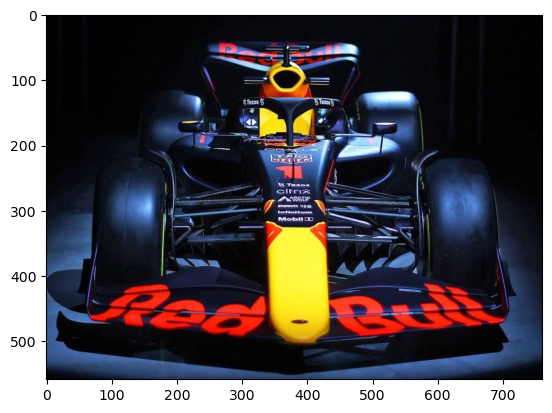

In [9]:
#Displaying the domain image
dimg = cv2.imread ("car.jpg")
dimage = cv2.cvtColor(dimg, cv2.COLOR_BGR2RGB)
dc = coords(0)
plt.imshow(dimage)



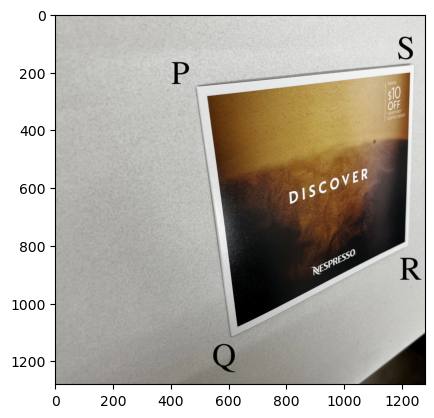

In [10]:
#Displaying the range image 1a
rimg1 = cv2.imread ("card1.jpeg")
rimage1 = cv2.cvtColor(rimg1, cv2.COLOR_BGR2RGB)
rc1 = coords(1)
plt.imshow(rimage1)



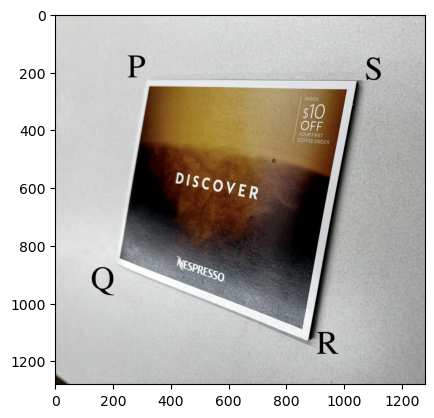

In [11]:
#Displaying the range image 1b
rimg2 = cv2.imread ("card2.jpeg")
rimage2 = cv2.cvtColor(rimg2, cv2.COLOR_BGR2RGB)
rc2 = coords(2)
plt.imshow(rimage2)

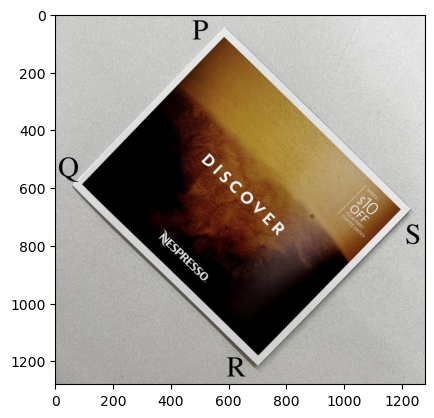

In [12]:
#Displaying the range image 1c
rimg3 = cv2.imread ("card3.jpeg")
rimage3 = cv2.cvtColor(rimg3, cv2.COLOR_BGR2RGB)
rc3 = coords(3)
plt.imshow(rimage3)

True

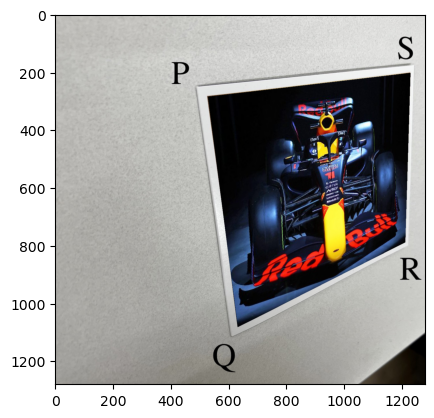

In [13]:
#Task 1a part i
H1 = proj_homography(dc,rc1) #Calculating the homography
rmask1 = masks(rimage1,rc1)  #Creating the mask
new_rimage1 = hom_mappingrev(dimage.copy(),rimage1.copy(),np.linalg.inv(H1),rc1,rmask1) #Generating the projection
new_rimage1 = cv2.cvtColor(new_rimage1,cv2.COLOR_RGB2BGR)
cv2.imwrite("Proj_car_card1.jpg",new_rimage1)


True

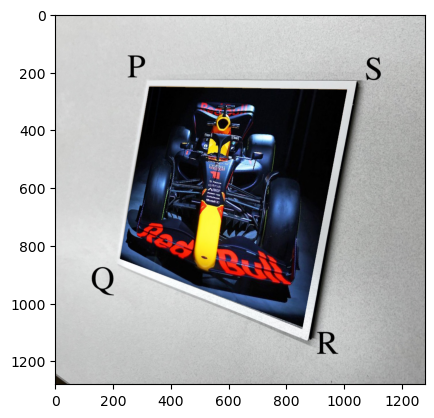

In [14]:
#Task 1a part ii
H2 = proj_homography(dc,rc2) #Calculating the homography
rmask2 = masks(rimage2,rc2)  #Creating the mask
new_rimage2 = hom_mappingrev(dimage.copy(),rimage2.copy(),np.linalg.inv(H2),rc2,rmask2) #Generating the projection
new_rimage2 = cv2.cvtColor(new_rimage2,cv2.COLOR_RGB2BGR)
cv2.imwrite("Proj_car_card2.jpg",new_rimage2)

True

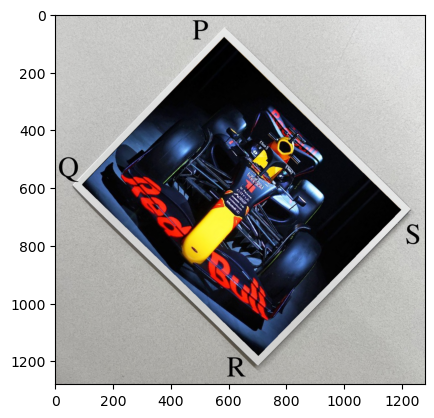

In [15]:
#Task 1a part iii
H3 = proj_homography(dc,rc3) #Calculating the homography
rmask3 = masks(rimage3,rc3)  #Creating the mask
new_rimage3 = hom_mappingrev(dimage.copy(),rimage3.copy(),np.linalg.inv(H3),rc3,rmask3) #Generating the projection
new_rimage3 = cv2.cvtColor(new_rimage3,cv2.COLOR_RGB2BGR)
cv2.imwrite("Proj_car_card3.jpg",new_rimage3)

True

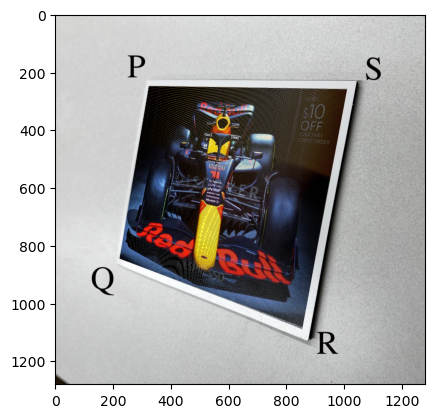

In [16]:
#Task 1a, using the domain coordinates to generate the range coordinates. Gives poor results
bad_rimage = hom_mapping(dimage.copy(),rimage2.copy(),H2,dc)
bad_rimage = cv2.cvtColor(bad_rimage,cv2.COLOR_RGB2BGR)
cv2.imwrite("BadProj_car_card2.jpg",bad_rimage)

True

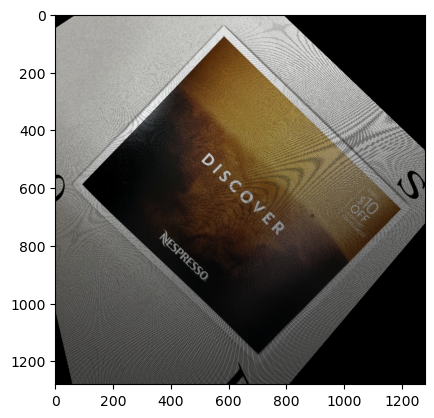

In [17]:
#Task 1b
#Calculating Homographies
H12 = proj_homography(rc1,rc2)
H23 = proj_homography(rc2,rc3)

fuse_rimage = hom_mappingfull(rimage1.copy(),rimage3.copy(),np.dot(H23,H12),rc1) #Generating the projection
fuse_rimage = cv2.cvtColor(fuse_rimage,cv2.COLOR_RGB2BGR)
cv2.imwrite("Proj_card1_card3.jpg",fuse_rimage)


True

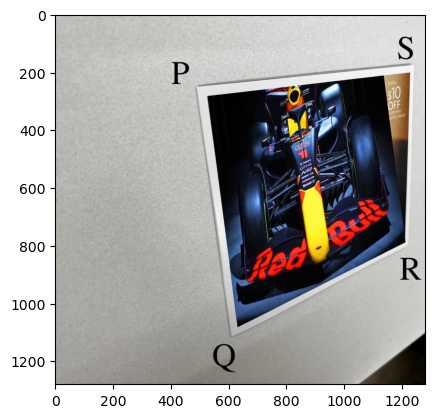

In [18]:
#Task 1c part i
aH1 = affine_homography(dc,rc1) #Calculating affine Homographies
anew_rimage1 = hom_mappingrev(dimage.copy(),rimage1.copy(),np.linalg.inv(aH1),rc1,rmask1) #Generating the projection
anew_rimage1 = cv2.cvtColor(anew_rimage1,cv2.COLOR_RGB2BGR)
cv2.imwrite("Affine_car_card1.jpg",anew_rimage1)


True

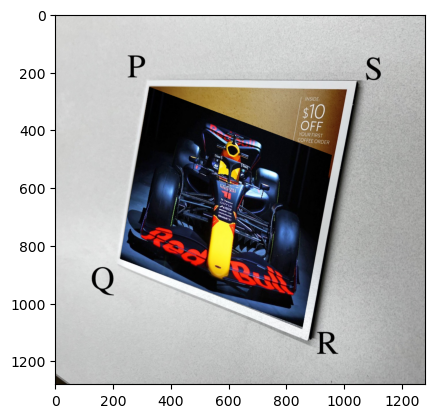

In [19]:
#Task 1c part ii
aH2 = affine_homography(dc,rc2) #Calculating affine Homographies
anew_rimage2 = hom_mappingrev(dimage.copy(),rimage2.copy(),np.linalg.inv(aH2),rc2,rmask2) #Generating the projection
anew_rimage2 = cv2.cvtColor(anew_rimage2,cv2.COLOR_RGB2BGR)
cv2.imwrite("Affine_car_card2.jpg",anew_rimage2)

True

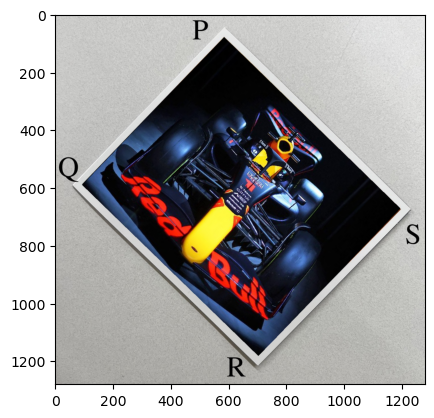

In [20]:
#Task 1c part iii
aH3 = affine_homography(dc,rc3) #Calculating affine Homographies
anew_rimage3 = hom_mappingrev(dimage.copy(),rimage3.copy(),np.linalg.inv(aH3),rc3,rmask3) #Generating the projection
anew_rimage3 = cv2.cvtColor(anew_rimage3,cv2.COLOR_RGB2BGR)
cv2.imwrite("Affine_car_card3.jpg",anew_rimage3)